# 1. Forutsetninger
Målet med denne notatboken er å få en forholdsvis enkel introduksjon til *reinforcement learning* (eller *forsterkende læring* på norsk), som er en gren av maskinlæring.

Vi skal løse problemet vist i denne videoen (NB. Kan være lurt å skru av lyd): https://www.youtube.com/watch?v=5Q14EjnOJZc.

Språket som benyttes er Python.

Notatboken består av delvis fullstendige, delvis ufullstendige funksjoner, kodesnutter og klasser. Oppgavene vil bestå i å fullføre de ufullstendige funksjonene og klassene, samt i å eksperimentere med ulike innstillinger for å oppnå bedre resultater på modeller laget for å løse problemet.

For å utføre ("eksekvere") koden i en celle i notatboken kan du bruke snarveien Shift+ENTER.

# 2. Nødvendige installasjoner

Vi trenger å installere noen få ekstra biblioteker for å få kjørt koden vår.

In [1]:
# Vi trenger dette for å vise videoer av oppførselen til modellene og strategiene vi lager.
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,301 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155629 fil

# 3. Hjelpeoppsett for visualisering

Vi begynner med litt generelt oppsett for å ta opp og vise videoer av modeller. Disse cellene trenger du bare å eksekvere (Shift + ENTER).

In [2]:
# Hjelpefunksjon for å spille av videoer

from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Denne funksjonen returnerer en streng som inneholder en base64-enkodet versjon av en MP4-video på angitt sti.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [3]:
# Importer et bibliotek for å embedde en MP4-video i et HTML-miljø
from IPython.display import HTML

For å vise en video lagret på `videopath` trenger du nå bare å skrive følgende kode:

```
html = render_mp4(videopath)
HTML(html)
```



Før vi går videre må vi instansiere et virtuelt display som kan håndtere visualisering for oss.

In [4]:
# Start opp en instans av et virtuelt display
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

# 4. CartPole-miljøet

Vi bruker et Python-bibliotek som heter `gym.openai`. Dette biblioteket er tilrettelagt for å studere en lang rekke *miljøer* ("environments") som er velegnet for reinforcement learning. I reinforcement learning er målet å trene en modell til å løse et fysisk problem ved å gi høyere poengsum jo nærmere modellen kommer å oppføre seg slik vi ønsker. Bak panseret brukes avansert matematikk for å søke etter de optimale input-verdiene som maksimerer poengsummen. Vi vil her få anlendning til å se noe av denne matematikken.

Ordet "modell" i maskinlæring kan godt tenkes på som en funksjon av mange variable, både diskret og kontinuerlige, som man er kommet fram til ved å trene på en lang rekke kjente data med tilhørende observasjoner av en "output"- eller "target"-variabel.

Vi skal studere *CartPole*-miljøet, et problem fra fysikken der studieobjektet er en vertikal stang montert på en bil. Bilen kan bevege seg i 2 retninger langs en fast horisontal akse. En slik stang er i ustabil likevekt og vil tippe mot høyre eller venstre ved små forstyrrelser. Målet er å holde stangen oppreist ved å respondere på hver enkelt forflytning av stangens topp. En *respons* ("action") kan være å gi bilen et dytt til venstre (0) eller et dytt til høyre (1).

Miljøets *tilstand* ("state") er til enhver tid beskrevet av fire variable:

1. Bilens posisjon
2. Bilens hastighet
3. Stangens vinkel målt mot en loddrett akse
4. Stangens vinkelhastighet.

Når vi skal trene en modell til å holde stangen oppreist skjer det gjennom flere *episoder*. En episode er et sett med *steg* ("steps"); for hvert steg skjer to ting:
- Man kan lese ut miljøets nåværende tilstand og får anledning til å reagere ved å dytte bilen mot venstre eller høyre.
- Miljøets tilstand oppdaterer seg som en respons på denne handlingen ("action")

"Å løse miljøet" betyr at man klarer å finne en universell måte å respondere på som gjør at stangen holdes oppreist i gjennomsnittlig mer enn 195 steg, målt over 100 påfølgende episoder. En episode varer et bestemt antall steg (minst 200), med mindre den termineres som følge av at miljøet *feiler*.

Miljøet feiler og episoden termineres dersom en av følgende skjer:
- stangens vinkel målt mot en vertikal linje blir større enn ±12° (ca 0.21 radianer)
- bilen beveger seg mer enn ±2.4

Oppgaven er altså å sørge for at dette ikke skjer.

La oss starte med å lage et CartPole-miljø og studere det litt.

In [5]:
import gym
import numpy as np

# Her oppretter vi miljøet vi skal studere
env = gym.make('CartPole-v0')

# Skriv ut en beskrivelse av miljøet:
print('Observation Space:', env.observation_space)
print('Action Space:', env.action_space)

print("Observation Space Param:   Cart Position | Cart Velocity | Pole Angle | Pole Velocity", )
print("Observation Space Highs:  ", env.observation_space.high)
print("Observation Space Lows:   ", env.observation_space.low)

Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action Space: Discrete(2)
Observation Space Param:   Cart Position | Cart Velocity | Pole Angle | Pole Velocity
Observation Space Highs:   [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Observation Space Lows:    [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


Hvordan tolker du utskriften over?

**Oppgave 1:**
Vi skal nå eksperimentere litt med miljøet. Først må miljøet resettes:

`env.reset()`

Dette sørger for å stille inn alle miljøets 4 variable til små utgangspunktsverdier.

Skriv en løkke som itererer 200 ganger, og for hver iterasjon generer en *random action* (altså et tilfeldig tall lik enten 0 eller 1), og deretter utfører denne handlingen på miljøet:
- For å generere et tilfeldig tall kan du bruke Numpy-funksjonen
`np.random.randint`.
- For å utføre en handling `action` på miljøet kan du bruke 
`env.step(action)`. Kan du finne ut hva denne funksjonen returnerer? Hint: Du kan bruke `help(env.step)`.

Skriv ut informasjonen du får hver gang det utføres en handling på miljøet. Hvordan tolker du hva som skjer med miljøet etterhvert?

In [7]:
help(env.step)

Help on method step in module gym.wrappers.time_limit:

step(action) method of gym.wrappers.time_limit.TimeLimit instance
    Run one timestep of the environment's dynamics. When end of
    episode is reached, you are responsible for calling `reset()`
    to reset this environment's state.
    
    Accepts an action and returns a tuple (observation, reward, done, info).
    
    Args:
        action (object): an action provided by the agent
    
    Returns:
        observation (object): agent's observation of the current environment
        reward (float) : amount of reward returned after previous action
        done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)



In [6]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Definer en VideoRecorder først
video = VideoRecorder(env, 'Test.mp4')

env.reset()

for i in range(200):
  print('i = {}'.format(i))
  action = np.random.randint(2)
  print('action = {}'.format(action))
  state, reward, done, info = env.step(action)
  print('state after action = {}'.format(state))
  print('reward from action = {}'.format(reward))
  if done:
    print('the environment has failed...')
  
  env.render()
  video.capture_frame()

video.close()
env.close()


i = 0
action = 1
state after action = [ 0.01757579  0.20022559 -0.02465535 -0.34249729]
reward from action = 1.0
i = 1
action = 1
state after action = [ 0.0215803   0.39568948 -0.0315053  -0.64285195]
reward from action = 1.0
i = 2
action = 0
state after action = [ 0.02949409  0.20102049 -0.04436233 -0.36025441]
reward from action = 1.0
i = 3
action = 0
state after action = [ 0.0335145   0.0065563  -0.05156742 -0.08188335]
reward from action = 1.0
i = 4
action = 0
state after action = [ 0.03364562 -0.18778997 -0.05320509  0.19409443]
reward from action = 1.0
i = 5
action = 1
state after action = [ 0.02988982  0.0080511  -0.0493232  -0.1148864 ]
reward from action = 1.0
i = 6
action = 1
state after action = [ 0.03005085  0.20384381 -0.05162093 -0.42271345]
reward from action = 1.0
i = 7
action = 0
state after action = [ 0.03412772  0.00948974 -0.0600752  -0.14674048]
reward from action = 1.0
i = 8
action = 0
state after action = [ 0.03431752 -0.18472276 -0.06301001  0.12640124]
reward f

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


i = 29
action = 1
state after action = [-0.40376872 -1.1889314   0.5873163   2.62382796]
reward from action = 0.0
the environment has failed...
i = 30
action = 1
state after action = [-0.42754735 -1.00092698  0.63979285  2.55199089]
reward from action = 0.0
the environment has failed...
i = 31
action = 1
state after action = [-0.44756589 -0.81376194  0.69083267  2.50229635]
reward from action = 0.0
the environment has failed...
i = 32
action = 0
state after action = [-0.46384113 -1.0063142   0.7408786   2.91223161]
reward from action = 0.0
the environment has failed...
i = 33
action = 1
state after action = [-0.48396741 -0.81899379  0.79912323  2.90333411]
reward from action = 0.0
the environment has failed...
i = 34
action = 1
state after action = [-0.50034729 -0.63216821  0.85718991  2.918637  ]
reward from action = 0.0
the environment has failed...
i = 35
action = 1
state after action = [-0.51299065 -0.44566012  0.91556265  2.95778045]
reward from action = 0.0
the environment has fa

Du kan gjøre opptak av oppførselen til miljøet underveis, ved hjelp av koden under:

```
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Definer en VideoRecorder først
videopath = 'passende navn på video.mp4'
video = VideoRecorder(env, videopath)

env.render()
video.capture_frame()
```
Du må kalle 

```
video.close()
env.close()
````

når du er ferdig. Deretter kan du hente fram videoen og se på den slik:

```
html = render_mp4(videopath)
HTML(html)
```

Hva syns du?

In [8]:
html = render_mp4('Test.mp4')
HTML(html)

# 5. Strategier
En *strategi* er en definert tilnærming for å løse CartPole-miljøet. Vi vil implementere strategier som *klasser* (se definisjon under).

**Definisjon:** I så godt som alle moderne programmeringsspråk har man muligheten til å definere sine egne typer, kalt *klasser*. En klasse består av medlemsvariable og -funksjoner. En instans av en klasse kalles et *objekt*. I Python har en klasse tilgang på sine egne funksjoner og variable gjennom en variabel som heter `self`. Alle medlemsfunksjoner av en klasse tar `self` som første parameter og kan endre på medlemsvariablene til den instansen av klassen de kalles innenfor.

Her er litt enkel bruk av klasser:

**Eksempel**:

```
class Eksempel():
  def __init__(self):
    self.variabel = 1

  def endre_variabel(self, tall):
    self.variabel = tall

a = Eksempel()     # a vil nå ha variabel == 1
a.endre_variabel(3) # a vil nå ha variabel == 3

b = Eksempel()     # b vil nå ha variabel == 1
b.endre_variabel(2) # b vil nå ha variabel == 2, a vil fortsatt ha variabel == 3
```


De klassene vi skal lage vil ha formen indikert nedenfor:

In [ ]:
class CartPoleStrategySkeleton():
    def __init__(self):
      # Her kan du definere hvilke operasjoner som skal utføres når et objekt av klassen instansieres
      pass

    def name(self):
      # Denne funksjonen skal returnere et passende navn/en passende beskrivelse av strategien
      return "LAG_ET_PASSENDE_NAVN_PÅ_STRATEGIEN_DIN"

    def act(self, state):
      # Legg til kode her. Denne funksjonen vil kalles når vi skal beregne en handling å utføre på miljøet, gitt miljøets tilstand (input til funksjonen).
      action = 0
      # ...
      return action

    def update(self):
      # Legg til kode her. Denne funksjonen er ment å kalles etter en fullført episode i tilfelle det er oppdateringer av klassevariable som må utføres på det tidspunktet.
      pass

    def memorize(self, state, action, reward, done):
      # Legg til kode her. Denne funksjonen er ment å kalles etter hver gang en handling er utført på miljøet, i tilfelle det er oppdateringer av klassevariable som må utføres på dette tidspunktet.
      pass
    

Koden over er en generell beskrivelse av strategiklassene vi skal skrive. Vi trenger også å skrive en funksjon som styrer treningen av en modell ved hjelp av en strategiklasse.

**Oppgave 2:** Skriv en funksjon `run_cartPole` som tar inn en strategiklasse som parameter og gjør følgende steg:
1. Lager en instans `env` av et `CartPole-v0`-miljø.
2. Itererer over 200 episoder, hver av dem på max 250 steg, og for hver episode forsøker å løse miljøet. Bruk funksjonene `act`, `memorize` og `update` til strategien.
3. Gjør opptak av oppførselen til miljøet underveis ved hjelp av følgende kommandoer:

```
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Definer en VideoRecorder først
video = VideoRecorder(env, 'passende navn på video.mp4')

env.render()
video.capture_frame()
```

4. Ta vare på en liste `scores` med belønningene du får underveis (for hver episode).

5. Funksjonen skal returnere listen `scores`. Husk at miljøet kun anses som løst dersom man klarer å holde stangen oppreist i 195 steg i 100 episoder etter hverandre (gjennomsnittlig).

6. Du må kalle
```
video.close()
env.close()
```
på slutten av funksjonen, før koden returnerer.

In [11]:
import numpy as np
from gym.envs.classic_control.cartpole import *
import time

from gym.wrappers.monitoring.video_recorder import VideoRecorder

def run_cartPole(policy):
    print('Evaluerer {}'.format(policy.name()))
    n_episodes = 200 # Vi skal sjekke 200 episoder
    max_t      = 250 # En episode skal vare 250 steg max

    # Definer miljøet
    env = gym.make('CartPole-v0')
    # Disse to linjene sørger for at ting er reproduserbart hver gang vi kjører.
    env.seed(0)
    np.random.seed(0)

    video_name = policy.name() + '.mp4'
    video = VideoRecorder(env, video_name)

    scores = []

    for i_episode in range(1, n_episodes+1):
        rewards = []
        # Her resetter vi miljøet
        state = env.reset()

        for t in range(max_t): # Maksium antall steg
            action = policy.act(state) # Finn hvilken handling vi skal gjøre
            state, reward, done, info = env.step(action) # Utføre handlingen
            rewards.append(reward) # Legg til belønning
            policy.memorize(state, action, reward, done)
            env.render()
            video.capture_frame()

            if done: # betyr at miljøet enten har feilet eller fullført riktig antall steg (195)
                break

        scores.append(sum(rewards))
        policy.update() # Kalles etter en fullført episode
        
        start = max(0, i_episode-100)
        print('Episode {}\tAverage score last <= 100 runs: {:.2f}\t Last score: {}'.format(i_episode, np.mean(scores[start:]), sum(rewards)))
        if np.mean(scores[start:]) >= 195.0 and len(scores[start:]) >= 100:
            print('** Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(max(1, i_episode-100+1), np.mean(scores[start:])))
            break

    start = max(0, i_episode-100)      
    if np.mean(scores[start:]) < 195.0:
        print('** The environment has never been solved!')
    
    video.close()
    env.close()
    
    return scores

**Oppgave 3a):** Test dette oppsettet på en strategi som alltid returnerer 1. Du kan utelate implementasjonen av funksjonene `update`, og `memorize`, de trengs ikke for en så enkel strategi (bruk Python-nøkkelordet `pass`). Men du må implementere funksjonen `act`.

Hvordan fungerer denne strategien på å løse miljøet?

In [10]:
class Policy_Always1():
    def __init__(self):
      pass

    def name(self):
      return "Alltid1"

    def act(self, state):
      return 1

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass

policy = Policy_Always1()
scores = run_cartPole(policy)
print('** Mean average score:', np.mean(scores))

Evaluerer Alltid1
Episode 1	Average score last runs: 10.00	 Last score: 10.0
Episode 2	Average score last runs: 9.50	 Last score: 9.0
Episode 3	Average score last runs: 9.00	 Last score: 8.0
Episode 4	Average score last runs: 9.50	 Last score: 11.0
Episode 5	Average score last runs: 9.20	 Last score: 8.0
Episode 6	Average score last runs: 9.17	 Last score: 9.0
Episode 7	Average score last runs: 9.29	 Last score: 10.0
Episode 8	Average score last runs: 9.25	 Last score: 9.0
Episode 9	Average score last runs: 9.22	 Last score: 9.0
Episode 10	Average score last runs: 9.20	 Last score: 9.0
Episode 11	Average score last runs: 9.09	 Last score: 8.0
Episode 12	Average score last runs: 9.25	 Last score: 11.0
Episode 13	Average score last runs: 9.15	 Last score: 8.0
Episode 14	Average score last runs: 9.14	 Last score: 9.0
Episode 15	Average score last runs: 9.20	 Last score: 10.0
Episode 16	Average score last runs: 9.12	 Last score: 8.0
Episode 17	Average score last runs: 9.18	 Last score: 10.

**Oppgave 3b)**
Hent fram videopptaket du har gjort av oppførselen til strategien over tid. Hva skjer?

In [12]:
html = render_mp4("Alltid1.mp4")
HTML(html)

# 6. Funksjoner som tegner utviklingen til en strategi

For å få bedre innblikk i hvordan en strategi potensielt tilnærmer seg en løsning på problemet, trenger vi å tegne oppførselen til strategien over flere episoder.

**Oppgave 4a)**

Bruk `matplotlib.pyplot` sin funksjon `scatter` til å skriv en funksjon `plot_performance`, som tar inn en liste `scores`, og tegner et scatter plot over disse langs y-akse mot episode på x-akse. Du kan bruke y-verdien til å fargelegge punktene. Prøv også å bruke koden under

```
fit = np.polyfit(x, y, deg=?)
p = np.poly1d(fit)
```

til å lage et polynom som interpolerer ("tilnærmer") y-verdiene, og plot grafen til dette polynomet. Dette kan gjøre det lettere å se om strategien utvikler seg på positivt vis over tid. Hva slags grad (`deg`) er det fornuftig å bruke på polynomet?

**Oppgave 4b)**
Skriv en funksjon `plot_histogram_scores`, som tar inn en liste `scores`, og tegner et histogram over fordelingen til belønningene per episode.


In [13]:
import matplotlib.pyplot as plt

def plot_performance(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(1, len(scores) + 1)
    y = scores
    plt.scatter(x, y, marker='x', c=y)
    fit = np.polyfit(x, y, deg=4)
    p = np.poly1d(fit)
    plt.plot(x, p(x), "r--")
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('Strategiytelse over tid')
    plt.show()

def plot_histogram_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(scores, facecolor='g', alpha=0.75)
    plt.ylabel('Frekvens')
    plt.xlabel('Belønning per episode')
    plt.title('Distribusjon av belønninger per episode')
    plt.show()

**Oppgave 4c)** Gjør et kall av disse funksjonene på `scores` som du allerede har hentet ut.

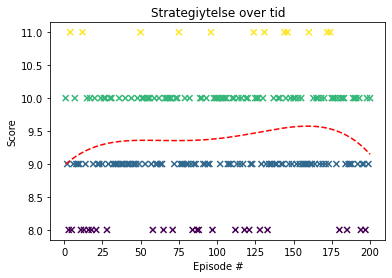

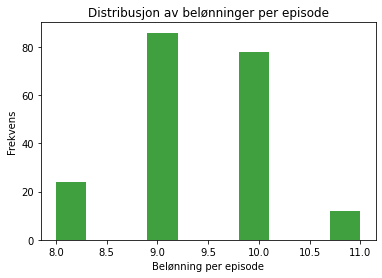

In [14]:
plot_performance(scores)
plot_histogram_scores(scores)

# 7. Noen andre strategier

Den forrige strategien var å alltid respondere med samme svar, uavhengig av hva miljøets tilstand tilsa. Vi kan istedet forsøke å variere mellom de to ulike handlingene 0 (dytt mot venstre) og 1 (dytt mot høyre). Den aller enkleste måten å variere på er å returnere et tilfeldig svar.

**Oppgave 5:** Implementer en slik strategiklasse. De trenger kun å implementere `act`-funksjonen. Tegn deretter ut de samme plottene som forrige gang, og inspiser videopptaket. Hvordan er denne strategien sammenlignet med den forrige? Hvorfor?

In [15]:
class Policy_Random():
    def __init__(self):
      pass

    def name(self):
      return "TilfeldigStrategi"

    def act(self, state):
      return np.random.randint(2)

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass

policy = Policy_Random()
scores = run_cartPole(policy)
print('** Mean average score:', np.mean(scores))

Evaluerer TilfeldigStrategi
Episode 1	Average score last <= 100 runs: 14.00	 Last score: 14.0
Episode 2	Average score last <= 100 runs: 13.00	 Last score: 12.0
Episode 3	Average score last <= 100 runs: 12.67	 Last score: 12.0
Episode 4	Average score last <= 100 runs: 14.50	 Last score: 20.0
Episode 5	Average score last <= 100 runs: 16.60	 Last score: 25.0
Episode 6	Average score last <= 100 runs: 15.50	 Last score: 10.0
Episode 7	Average score last <= 100 runs: 15.86	 Last score: 18.0
Episode 8	Average score last <= 100 runs: 15.38	 Last score: 12.0
Episode 9	Average score last <= 100 runs: 14.89	 Last score: 11.0
Episode 10	Average score last <= 100 runs: 14.90	 Last score: 15.0
Episode 11	Average score last <= 100 runs: 18.64	 Last score: 56.0
Episode 12	Average score last <= 100 runs: 18.58	 Last score: 18.0
Episode 13	Average score last <= 100 runs: 18.00	 Last score: 11.0
Episode 14	Average score last <= 100 runs: 18.36	 Last score: 23.0
Episode 15	Average score last <= 100 runs: 

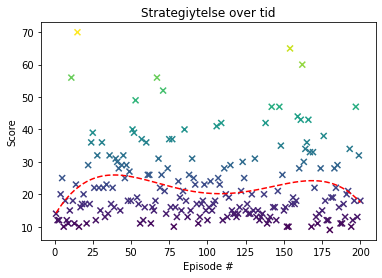

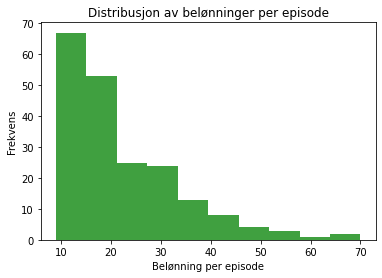

In [16]:
plot_performance(scores)
plot_histogram_scores(scores)

In [17]:
html = render_mp4('TilfeldigStrategi.mp4')
HTML(html)

La oss forsøke å forbedre strategien enda litt mer. Det kan vi gjøre ved å faktisk tilpasse handlingen etter hvordan miljøets tilstand er. For eksempel kan vi skyve bilen mot venstre dersom stangen tipper i denne retningen. Og mot høyre hvis den tipper i den retningen.

**Oppgave 6:**
Skriv en slik strategiklasse, `Policy_BasicConditionalBangControl`. Du trenger kun å implementere `act`-funksjonen. Tegn ut de samme plottene som tidligere og inspiser videopptaket. Hvordan er oppførselen til strategien nå?

In [18]:
class Policy_BasicConditionalBangControl():
    def __init__(self):
      pass

    def name(self):
      return "BangControlStrategi"

    def act(self, state):
      observation_angle = state[2]  # Dette er den observerte vinkelen til stangen
      if observation_angle < 0:
        return 0
      else:
        return 1

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      pass

policy = Policy_BasicConditionalBangControl()
scores = run_cartPole(policy)

Evaluerer BangControlStrategi
Episode 1	Average score last <= 100 runs: 45.00	 Last score: 45.0
Episode 2	Average score last <= 100 runs: 45.50	 Last score: 46.0
Episode 3	Average score last <= 100 runs: 44.33	 Last score: 42.0
Episode 4	Average score last <= 100 runs: 43.00	 Last score: 39.0
Episode 5	Average score last <= 100 runs: 39.60	 Last score: 26.0
Episode 6	Average score last <= 100 runs: 40.33	 Last score: 44.0
Episode 7	Average score last <= 100 runs: 40.00	 Last score: 38.0
Episode 8	Average score last <= 100 runs: 39.50	 Last score: 36.0
Episode 9	Average score last <= 100 runs: 40.00	 Last score: 44.0
Episode 10	Average score last <= 100 runs: 40.20	 Last score: 42.0
Episode 11	Average score last <= 100 runs: 40.18	 Last score: 40.0
Episode 12	Average score last <= 100 runs: 40.17	 Last score: 40.0
Episode 13	Average score last <= 100 runs: 40.15	 Last score: 40.0
Episode 14	Average score last <= 100 runs: 39.86	 Last score: 36.0
Episode 15	Average score last <= 100 runs

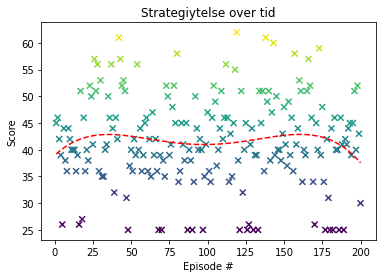

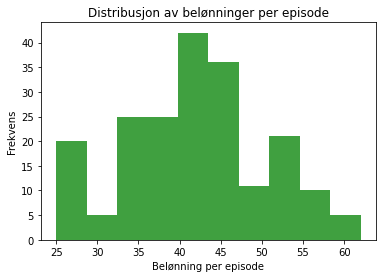

In [19]:
plot_performance(scores)
plot_histogram_scores(scores)

In [20]:
html = render_mp4('BangControlStrategi.mp4')
HTML(html)

**Oppgave 7:** Kan du komme på en egen strategi for å løse problemet? For eksempel forbedre tilnærmingen over og skrive en `Policy_ImprovedConditionalBangControl`? *Hint*: Her gjelder det å se på andre parametre som beskriver miljøets tilstand, i hovedsak stangens vinkelhastighet og bilens hastighet.

Tegn ut ytelsesplottene og inspiserer videopptaket av strategilæringen som før. Hva syns du?

In [21]:
class Policy_ImprovedConditionalBangControl():
    def __init__(self):
      pass

    def name(self):
      return "ImprovedBangControlStrategi"

    def act(self, state):
      angle = state[2]  # Dette er den observerte vinkelen til stangen
      angle_vel = state[3] # Dette er stangens vinkelhastighet
      if np.sign(angle * angle_vel) > 0:
        return 1
      else:
        return 0

    def update(self):
      pass

    def memorize(self, state, action, reward, done):
      # Explain purpose
      pass

policy = Policy_ImprovedConditionalBangControl()
scores = run_cartPole(policy)

Evaluerer ImprovedBangControlStrategi
Episode 1	Average score last <= 100 runs: 200.00	 Last score: 200.0
Episode 2	Average score last <= 100 runs: 180.50	 Last score: 161.0
Episode 3	Average score last <= 100 runs: 156.00	 Last score: 107.0
Episode 4	Average score last <= 100 runs: 153.25	 Last score: 145.0
Episode 5	Average score last <= 100 runs: 144.00	 Last score: 107.0
Episode 6	Average score last <= 100 runs: 144.83	 Last score: 149.0
Episode 7	Average score last <= 100 runs: 147.86	 Last score: 166.0
Episode 8	Average score last <= 100 runs: 130.50	 Last score: 9.0
Episode 9	Average score last <= 100 runs: 117.00	 Last score: 9.0
Episode 10	Average score last <= 100 runs: 106.20	 Last score: 9.0
Episode 11	Average score last <= 100 runs: 97.27	 Last score: 8.0
Episode 12	Average score last <= 100 runs: 101.58	 Last score: 149.0
Episode 13	Average score last <= 100 runs: 94.38	 Last score: 8.0
Episode 14	Average score last <= 100 runs: 88.29	 Last score: 9.0
Episode 15	Average s

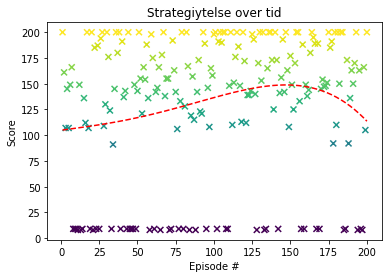

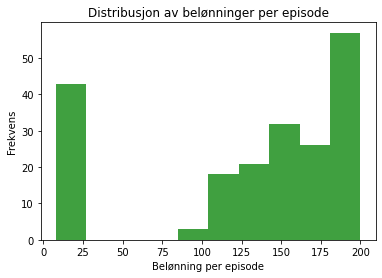

In [ ]:
plot_performance(scores)
plot_histogram_scores(scores)

In [ ]:
html = render_mp4('ImprovedBangControlStrategi.mp4')
HTML(html)

# 8. Hill climbing

For å løse miljøet er en mulig tilnærming å vekte de forskjellige variablene som beskriver tilstanden til miljøet. Med andre ord, vi må prøve å finne vekter (reelle tall) `w_1, w_2, w_3 og w_4` slik at summen

`w_1 * bilens_posisjon + w_2 * bilens_hastighet + w_3 * stangens_vinkel + w_4 * stangens_vinkel_hastighet`

entydig forteller oss om vi skal dytte bilen mot høyre eller venstre. Den enkleste måten å la en slik sum avgjøre et valg som i utgangspunktet bare har to muligheter (venstre eller høyre, 0 eller 1), er å se på om den er positiv eller negativ. Vi kan for eksempel si at dersom summen, for gitte vekter `w_1, ... w_4`, er negativ, så skal vi dytte bilen mot venstre, mens vi skal dytte mot høyre om den er positiv.

**Oppgave 8a)** Skriv en strategiklasse `PolicyReinforcementLearning` som eier en liste `self.w` med fire reelle vekter, og som implementerer funksjonen `act` ved å sjekke om summen gjengitt ovenfor er positiv eller negativ. Du kan sette alle fire vektene til f. eks. 0.1 i `__init__`-funksjonen til klassen.

**Oppgave 8b)** *Reinforcement learning* betyr at vi søker å belønne riktig atferd i strategiklassen. Det vil si at vi oppdaterer vektene `w_1, ... w_4` i strategiklassen etter hver fullendte episode basert på hvor høy score vi fikk. Var scoren høy tolker vi det som at vektene var "gode" og endrer dem ikke så mye. Var scoren lav tolker vi det som at vektene ikke var så gode, og vi endrer dem da litt mer før neste episode.

Dette betyr at vi er nødt til å ta vare på belønningene vi får for hver episode.Skriv funksjonen `memorize` i strategiklassen slik at den tar vare på belønningene for hver handling i en liste `self.rewards`.

**Oppgave 8c)** Du skal nå skrive funksjonen `update` slik at den oppdaterer vektene basert på om vi har klart å forbedre belønningen for handlingene våre. I avansert *reinforcement learning* bruker man gjerne noe som heter *backpropagation* for å beregne deriverte og *gradient descent* for å justere vektene i helt riktig retning. Dette blir for komplisert for dette kurset, istedet skal vi gjøre en enkel justering av vektene ved hjelp av tilfeldigheter.

Hvis belønningen har forbedret seg siden forrige episode, kan du justere vektene **litt** i tilfeldig retning, mens hvis belønningen har forverret seg må du justere vektene **mye**.

**Oppgave 8d)** Prøv å kjøre strategien nå. Fungerer det?

**Oppgave 8e)** For en enda bedre strategilæring kan det være lurt å legge mindre og mindre vekt på nyere belønninger. Dette hindrer læringen til strategien fra å bli overopphengt i de siste resultatene. Vi kan legge til en ny variabel `gamma` og bruke en vektet sum av de foregående belønningene som mål på godt vi har lykkes. Første belønning vektes med `gamma^0 = 1.0`, andre belønning med `gamma`, tredje med `gamma^2`, fjerde med `gamma^3` osv. Forsøk å variere variablen `gamma` mellom 0 og 1. Hvordan endrer oppførselen til strategilæringen seg?

In [22]:
class PolicyReinforcementLearning():
    def __init__(self):
        self.rewards = []
        self.best_R = -np.Inf
        self.w = 1.0e-4*np.array([1.0, 1.0, 1.0, 1.0])
        self.best_w = self.w      # Vi initialiserer på trivielt vis
        self.w_history = [self.w] # Historikk over vektene, for visualisering av utvikling over tid
        self.gamma = 0.95         # Rate for nedvekting av belønninger
        self.noise_scale = 1.0e-2 # Standardavvik for additiv støy


    def name(self):
        return "ReinforcementLearning"    

    def act(self, state):
        if np.dot(state, self.w) < 0:
            return 0
        else:
            return 1

    def memorize(self, state, action, reward, done):
        self.rewards.append(reward)

    def update(self):
        discounts = [self.gamma**i for i in range(len(self.rewards)+1)]
        self.R = sum([a*b for a, b in zip(discounts, self.rewards)])

        if self.R >= self.best_R: # Vektene ble bedre enn før
            self.best_R = self.R
            self.best_w = self.w
            self.noise_scale = max(1.0e-3, self.noise_scale / 2.0) # Gjør støy mindre, fordi vi gjør fremgang og ikke vil endre så mye på vektene
        else: # Vektene var ikke bedre enn før
            self.noise_scale = min(2.0, self.noise_scale * 2.0) # Gjør støy større fordi vi feiler og trenger større justering av vektene
        
        self.w = self.best_w + self.noise_scale * np.random.rand(*self.w.shape)

        self.w_history.append(self.w)
        self.rewards = []


policy = PolicyReinforcementLearning()
scores = run_cartPole(policy)
print('** Mean average score:', np.mean(scores))

Evaluerer ReinforcementLearning
Episode 1	Average score last <= 100 runs: 200.00	 Last score: 200.0
Episode 2	Average score last <= 100 runs: 175.00	 Last score: 150.0
Episode 3	Average score last <= 100 runs: 168.00	 Last score: 154.0
Episode 4	Average score last <= 100 runs: 141.75	 Last score: 63.0
Episode 5	Average score last <= 100 runs: 115.00	 Last score: 8.0
Episode 6	Average score last <= 100 runs: 129.17	 Last score: 200.0
Episode 7	Average score last <= 100 runs: 139.29	 Last score: 200.0
Episode 8	Average score last <= 100 runs: 146.88	 Last score: 200.0
Episode 9	Average score last <= 100 runs: 152.78	 Last score: 200.0
Episode 10	Average score last <= 100 runs: 157.50	 Last score: 200.0
Episode 11	Average score last <= 100 runs: 161.36	 Last score: 200.0
Episode 12	Average score last <= 100 runs: 163.83	 Last score: 191.0
Episode 13	Average score last <= 100 runs: 166.62	 Last score: 200.0
Episode 14	Average score last <= 100 runs: 169.00	 Last score: 200.0
Episode 15	Ave

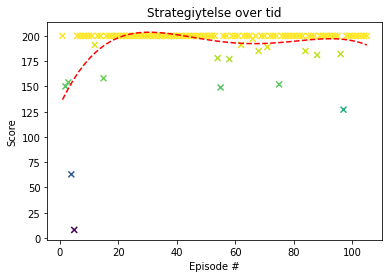

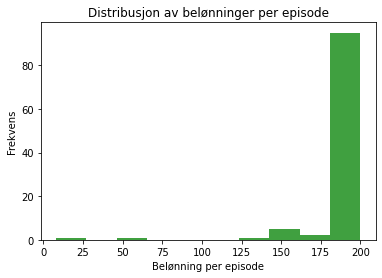

In [23]:
plot_performance(scores)
plot_histogram_scores(scores)

In [24]:
html = render_mp4('ReinforcementLearning.mp4')
HTML(html)

**Oppgave 8f)** Se på videopptaket av strategiens oppførsel. Hva synes du?

**Oppgave 8g)** Ta vare på vektene som genereres av strategiklassen underveis, i en variabel `self.w_history`. Skriv en funksjon `plot_weights_history` som tegner utviklingen til hver av dem som funksjon av antall episoder. Hva observerer du?

In [25]:
def plot_weights_history(weights_history):
    weights_history = np.array(weights_history)
    plt.figure(0)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.6, hspace=.5)
    for i in range(weights_history.shape[1]):
        plt.subplot(2, 2, i + 1)
        plt.plot(weights_history[:, i])
        plt.title('Vekt for miljøtilstandsparameter {}'.format(i))

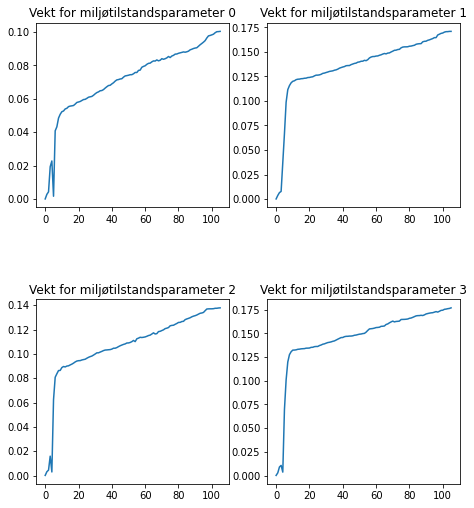

In [26]:
plot_weights_history(policy.w_history)

Det vi har konstruert nå er et veldig enkelt kunstig nevralt nettverk med ett lag som kun manipulerer input-data med vekter, summerer og anvender en aktiveringsfunksjon. Dette kalles et *perseptron*:

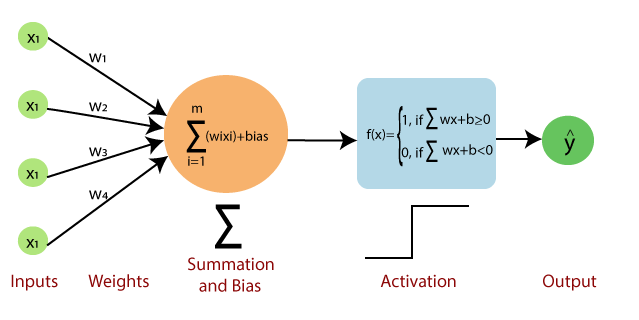

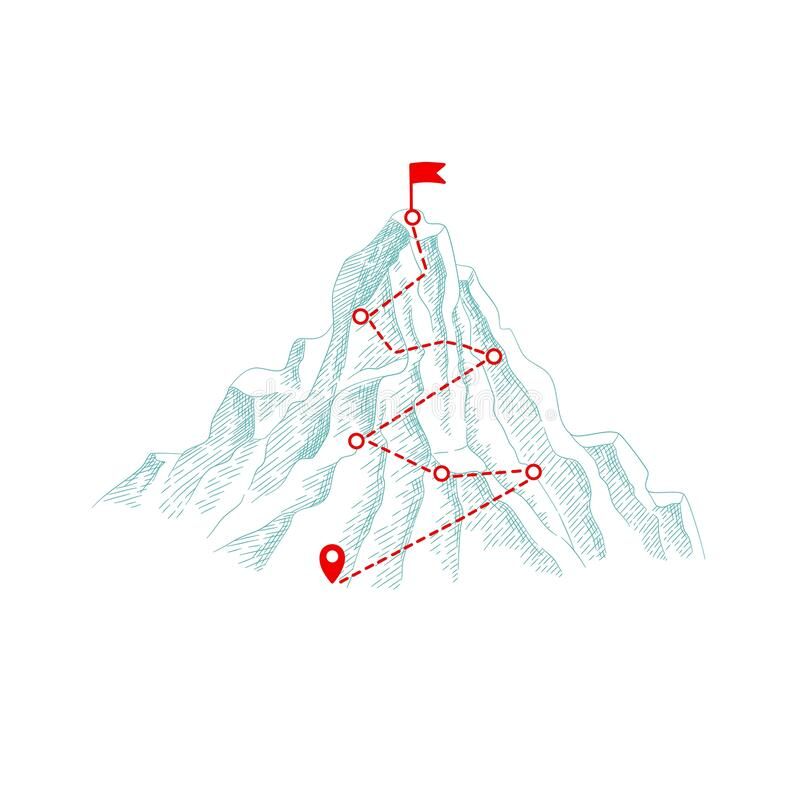

Du kan lese mer om nevrale nettverk her:
- https://towardsdatascience.com/machine-learning-for-beginners-an-introduction-to-neural-networks-d49f22d238f9
- https://www.lesswrong.com/posts/Madwb2t79LGrLqWLH/a-simple-introduction-to-neural-networks (denne krever en del mer matematikk)

Med denne tilnærmingen ser det tilsynelatende ut til at vi har greid å holde stangen oppreist, men likefullt kan det virke som om strategien favoriserer at stangens toppunkt ikke skal bevege seg så mye. Funksjonen under kan brukes til å verifisere om strategien holder over lenger tid:

In [27]:
import requests

def validate_policy(policy, stable = False, write_score = False, player_name = "Test", board_code=""):
    name = policy.name()
    print("Validerer strategien {}...".format(name))
    max_t = 500 # Høyt antall makssteg

    # Definer miljøet
    env = gym.make('CartPole-v0')    
    
    if stable:
        # Disse to linjene sørger for at ting er reproduserbart
        env.seed(2022)
        np.random.seed(2022)

    video_name = "Validation_{}.mp4".format(name)
    video = VideoRecorder(env, video_name)

    state = env.reset()
    rewards = []    

    for t in range(max_t): # Maksium antall steg 
        action = policy.act(state) # Finn hvilken handling vi skal gjøre
        state, reward, done, info = env.step(action) # Utføre handlingen
        rewards.append(reward) # Legg til belønning
        env.render()
        video.capture_frame()
      
    print("Strategien fikk en score på {}".format(sum(rewards)))
    video.close()
    env.close()

    if write_score:
        id = -1
        previous_score = 0
        r = requests.get("https://keepthescore.co/api/{}/board/".format(board_code))
        for player in r.json()['players']:
            if player['name'] == player_name:
                id = player['id']
                previous_score = player['score']
                break
        if id != -1:
            print('Bruker allerede registrert...')
        else:
            print('Registrerer ny bruker...')
            r = requests.post("https://keepthescore.co/api/{}/player/".format(board_code), json={"name": player_name})
            print(r.status_code, r.reason)
            for player in r.json()['players']:
                if player['name'] == player_name:
                    id = player['id']
                    break
        if id != -1:
            print('Skriver score til leaderboard...')
            r = requests.post("https://keepthescore.co/api/{}/score/".format(board_code), json={"player_id": id, "score": sum(rewards)-previous_score})
            print(r.status_code, r.reason)

    return sum(rewards), video_name

**Oppgave 9:** Sjekk strategien din med denne valideringsfunksjonen.

In [28]:
points, video_name = validate_policy(policy)

Validerer strategien ReinforcementLearning...


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Strategien fikk en score på 280.0


In [29]:
html = render_mp4(video_name)
HTML(html)

Det er mulig å lage en enda bedre utgave av klassen over ved å finpusse tilnærmingen til `act`, som indikert nedenfor. Istedenfor å operere med 4 vekter som entydig skal fortelle oss om vi skal dytte mot høyre eller venstre, lager vi 4 vekter som skal fortelle oss hvor mye det kan lønne seg å dytte til venstre, og 4 vekter som skal fortelle oss hvor mye det kan lønne seg å dytte til høyre. Deretter velger vi den veien som lønner seg mest.

**Oppgave 10:** Skriv en forbedret utgave av forrige strategiklasse, der du vedlikeholder to vektlister istedenfor én, en for å beregne lønnsomheten til en venstre-*action*, og en for å beregne lønnsomheten til en høyre-*action*. I `act`-funksjonen velger du den handlingen som gir størst lønnsomhet. `memorize` er som før, og `update` må nå holde kontroll på to størrelser fremfor bare én.

In [30]:
class PolicyImprovedReinforcementLearning():
    def __init__(self):
        self.rewards = []
        self.best_R = -np.Inf
        self.w_left =  1.0e-4*np.array([1.0, 1.0, 1.0, 1.0])
        self.w_right = 1.0e-4*np.array([1.0, 1.0, 1.0, 1.0])
        self.best_w_left = self.w_left
        self.best_w_right = self.w_right
        self.w_history_left = [self.w_left]
        self.w_history_right = [self.w_right]
        self.gamma = 0.95         # Rate for nedvekting av belønninger
        self.noise_scale = 1.0e-2 # Standardavvik for additiv støy

    def name(self):
        return "ImprovedRL"

    def act(self, state):
        score_left = np.dot(state, self.w_left)
        score_right = np.dot(state, self.w_right)
        # Ikke sikkert man trenger å bruke exp selv om det matematisk sett er ryddigere
        score_left_norm = np.exp(score_left) / (np.exp(score_left) + np.exp(score_right))
        score_right_norm = np.exp(score_right) / (np.exp(score_left) + np.exp(score_right))
        if score_left > score_right:
            return 0
        else:
            return 1

    def memorize(self, next_state, action, reward, done):
        self.rewards.append(reward)

    def update(self):
        discounts = [self.gamma**i for i in range(len(self.rewards)+1)]
        self.R = sum([a*b for a,b in zip(discounts, self.rewards)])

        if self.R >= self.best_R:
            self.best_R = self.R
            self.best_w_left = self.w_left
            self.best_w_right = self.w_right
            self.noise_scale = max(1.0e-3, self.noise_scale / 2.0)
        else:
            self.noise_scale = min(2.0, self.noise_scale * 2.0)        

        self.w_left = self.best_w_left + self.noise_scale * np.random.rand(*self.w_left.shape)
        self.w_right = self.best_w_right + self.noise_scale * np.random.rand(*self.w_right.shape)
        self.w_history_left.append(self.w_left)
        self.w_history_right.append(self.w_right)
        self.rewards = []


In [31]:
policy = PolicyImprovedReinforcementLearning()
scores = run_cartPole(policy)
print('** Mean average score:', np.mean(scores))

Evaluerer ImprovedRL
Episode 1	Average score last <= 100 runs: 10.00	 Last score: 10.0
Episode 2	Average score last <= 100 runs: 46.00	 Last score: 82.0
Episode 3	Average score last <= 100 runs: 33.33	 Last score: 8.0
Episode 4	Average score last <= 100 runs: 31.25	 Last score: 25.0
Episode 5	Average score last <= 100 runs: 45.80	 Last score: 104.0
Episode 6	Average score last <= 100 runs: 48.33	 Last score: 61.0
Episode 7	Average score last <= 100 runs: 44.29	 Last score: 20.0
Episode 8	Average score last <= 100 runs: 39.88	 Last score: 9.0
Episode 9	Average score last <= 100 runs: 39.67	 Last score: 38.0
Episode 10	Average score last <= 100 runs: 41.00	 Last score: 53.0
Episode 11	Average score last <= 100 runs: 40.09	 Last score: 31.0
Episode 12	Average score last <= 100 runs: 37.67	 Last score: 11.0
Episode 13	Average score last <= 100 runs: 35.38	 Last score: 8.0
Episode 14	Average score last <= 100 runs: 47.14	 Last score: 200.0
Episode 15	Average score last <= 100 runs: 53.80	 L

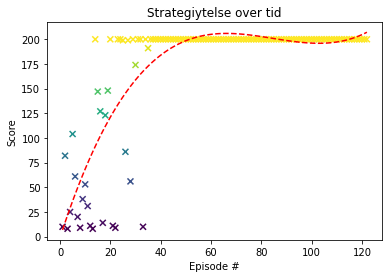

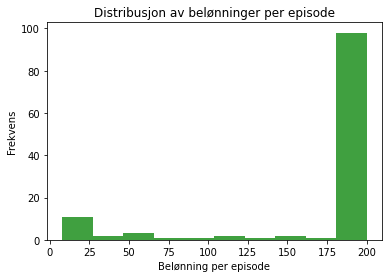

In [32]:
plot_performance(scores)
plot_histogram_scores(scores)

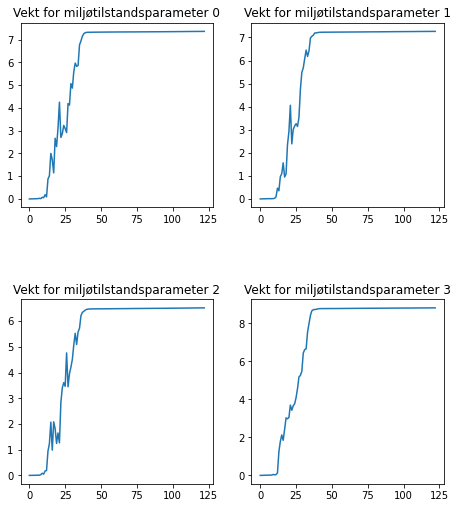

In [33]:
plot_weights_history(policy.w_history_right)

In [34]:
points, video_name = validate_policy(policy)

Validerer strategien ImprovedRL...


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Strategien fikk en score på 472.0


In [35]:
html = render_mp4(video_name)
HTML(html)

## 9. Konkurranse

**Oppgave 11:** Bruk `validate_policy(policy, True, True, "DITT_BRUKERNAVN", board_code)` til å sjekke hvor god strategien din er. `board_code` får du fra instruktørene. Beste score vinner! :) Du kan forsøke å endre på strategien din ved behov. For eksempel stille inn på variable som `gamma` o.l. (i maskinlæring omtales slike variable gjerne som *hyperparametre* og prosessen med å finne de beste hyperparametrene for formålet til modellen kalles gjerne *hyperparameter-tuning*).

In [36]:
validate_policy(policy, True, True, "Nikolay", "qpoqmtumwue")

Validerer strategien ImprovedRL...


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Strategien fikk en score på 498.0
Registrerer ny bruker...
200 OK
Skriver score til leaderboard...
201 Created


(498.0, 'Validation_ImprovedRL.mp4')

# 10. Trene en modell ved hjelp av ray.rllib

Det vi nå har gjort er å lage vår egen, helt grunnleggende *reinforcement learning*-algoritme, spesialtilpasset et konkret problem, med forholdsvis enkel matematikk. Det finnes mer generelle tilnærminger, som tar i bruk kraftigere matematiske verktøy og enkelt kan tilpasses andre problemer. For eksempel kan man benytte Rays bibliotek `RLLib`. Vi må da først installere biblioteket:

In [ ]:
!pip install 'ray[rllib]'

     |████████████████████████████████| 52.7 MB 89 kB/s 
     |████████████████████████████████| 4.1 MB 38.6 MB/s 
     |████████████████████████████████| 225 kB 53.0 MB/s 
     |████████████████████████████████| 1.2 MB 48.1 MB/s 
     |████████████████████████████████| 125 kB 44.8 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


`RLLib` er ferdig tilpasset `gym.openai`.

In [ ]:
config = {                        # Det er mulig å modifisere konfigurasjonen - se https://docs.ray.io/en/latest/rllib-models.html
    "env": "CartPole-v0",         # Med dette forteller vi RLLib at vi jobber med CartPole-v0-miljøet som biblioteket allerede kjenner til
    "framework": "torch",         # Spesifiser hvilket maskinlæringsrammeverk som skal benyttes (PyTorch = "torch", Tensorflow = "tf")
    "model": {                    # Spesifiserer egenskaper ved det nevrale nettverket som skal benyttes til læring (se f.eks. https://en.wikipedia.org/wiki/Artificial_neural_network)
      "fcnet_hiddens": [32],      # Antall "hidden layers" i det nevrale nettverket
      "fcnet_activation": "linear"# Aktiveringsfunksjon, kan også være "tanh" (https://en.wikipedia.org/wiki/Hyperbolic_functions#Tanh), "relu" (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
    }
}  

In [ ]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

ray.shutdown()                        # Stop eventuelle instanser
ray.init(                             # Sett opp ny instans med visse parametre
    num_cpus = 3,
    include_dashboard = False,
    ignore_reinit_error = True,
    log_to_driver = False,
)
# https://docs.ray.io/en/latest/tune/api_docs/execution.html
analysis = ray.tune.run(              # Begynn trening
    "PPO",                            # Valg av innebygd treningsalgoritme
    config = config,                  # Konfigurasjon
    stop = { 
        "episode_reward_mean": 195    # Vi stopper treningen når snitt-belønning går over 195
    },                        
    checkpoint_at_end = True,         # Må tas vare på for gjenbruk etterpå
    verbose = 2                       # Hvor mye rapporteringer skal vi ha underveis i treningen?
)

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=84.0,episode_reward_min=9.0,episode_reward_mean=22.930635838150287,episode_len_mean=22.930635838150287,episode_media={},episodes_this_iter=173,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2291177447965996, 'mean_inference_ms': 1.5234795395456247, 'mean_action_processing_ms': 0.1044061214212755, 'mean_env_wait_ms': 0.15291008040697782, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=4000,timers={'sample_time_ms': 4779.784, 'sample_throughput': 836.858, 'load_time_ms': 0.526, 'load_throughput': 7601819.665, 'learn_time_ms': 4175.284, 'learn_throughput': 958.019, 'update_time_ms': 2.764},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 274.0994264171969, 'polic

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=106.0,episode_reward_min=10.0,episode_reward_mean=28.985401459854014,episode_len_mean=28.985401459854014,episode_media={},episodes_this_iter=137,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2227033904243499, 'mean_inference_ms': 1.4935893852315687, 'mean_action_processing_ms': 0.10190675875312066, 'mean_env_wait_ms': 0.1444972314328769, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=8000,timers={'sample_time_ms': 6470.864, 'sample_throughput': 618.155, 'load_time_ms': 0.504, 'load_throughput': 7941877.396, 'learn_time_ms': 4081.017, 'learn_throughput': 980.148, 'update_time_ms': 3.256},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 350.69542372508715, 'po

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=10.0,episode_reward_mean=39.450980392156865,episode_len_mean=39.450980392156865,episode_media={},episodes_this_iter=102,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.21791275372765023, 'mean_inference_ms': 1.4861411123429904, 'mean_action_processing_ms': 0.10240928190307924, 'mean_env_wait_ms': 0.14347635573336448, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=12000,timers={'sample_time_ms': 6974.625, 'sample_throughput': 573.508, 'load_time_ms': 0.499, 'load_throughput': 8023537.064, 'learn_time_ms': 4099.863, 'learn_throughput': 975.642, 'update_time_ms': 3.502},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 725.8049026817404, '

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=178.0,episode_reward_min=10.0,episode_reward_mean=54.83,episode_len_mean=54.83,episode_media={},episodes_this_iter=62,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.21477742105529113, 'mean_inference_ms': 1.4778630058516895, 'mean_action_processing_ms': 0.10188602896866775, 'mean_env_wait_ms': 0.14179054771868838, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=16000,timers={'sample_time_ms': 7235.7, 'sample_throughput': 552.815, 'load_time_ms': 0.492, 'load_throughput': 8124559.806, 'learn_time_ms': 4095.269, 'learn_throughput': 976.737, 'update_time_ms': 3.335},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1062.6515738538517, 'policy_loss': -0.01427374693

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=10.0,episode_reward_mean=72.42,episode_len_mean=72.42,episode_media={},episodes_this_iter=50,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.21148591473563802, 'mean_inference_ms': 1.4782936981629191, 'mean_action_processing_ms': 0.10219412954608434, 'mean_env_wait_ms': 0.1411886526949653, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=20000,timers={'sample_time_ms': 7415.807, 'sample_throughput': 539.388, 'load_time_ms': 0.486, 'load_throughput': 8226545.062, 'learn_time_ms': 4059.747, 'learn_throughput': 985.283, 'update_time_ms': 3.16},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.10000000000000002, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1415.497708031439, 'policy_loss': -0.016146585673

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=15.0,episode_reward_mean=92.31,episode_len_mean=92.31,episode_media={},episodes_this_iter=35,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.20984200830012298, 'mean_inference_ms': 1.4785464734039702, 'mean_action_processing_ms': 0.10232825276048503, 'mean_env_wait_ms': 0.14054626807833628, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=24000,timers={'sample_time_ms': 7482.842, 'sample_throughput': 534.556, 'load_time_ms': 0.491, 'load_throughput': 8150874.17, 'learn_time_ms': 4090.046, 'learn_throughput': 977.984, 'update_time_ms': 3.117},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.05000000000000001, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1751.0943270119287, 'policy_loss': -0.0125985876

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=15.0,episode_reward_mean=112.99,episode_len_mean=112.99,episode_media={},episodes_this_iter=24,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2083261035065599, 'mean_inference_ms': 1.4782898549061128, 'mean_action_processing_ms': 0.10235049383889709, 'mean_env_wait_ms': 0.14006593340554246, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=28000,timers={'sample_time_ms': 7588.91, 'sample_throughput': 527.085, 'load_time_ms': 0.49, 'load_throughput': 8158990.691, 'learn_time_ms': 4086.273, 'learn_throughput': 978.887, 'update_time_ms': 3.041},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.025000000000000005, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1696.1803951796664, 'policy_loss': -0.010996874

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=15.0,episode_reward_mean=135.44,episode_len_mean=135.44,episode_media={},episodes_this_iter=22,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.20732325373819396, 'mean_inference_ms': 1.4805572052362412, 'mean_action_processing_ms': 0.10265243964593446, 'mean_env_wait_ms': 0.14002173438407317, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=32000,timers={'sample_time_ms': 7692.935, 'sample_throughput': 519.958, 'load_time_ms': 0.497, 'load_throughput': 8054835.744, 'learn_time_ms': 4087.891, 'learn_throughput': 978.5, 'update_time_ms': 3.304},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.012500000000000002, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1757.6407582929057, 'policy_loss': -0.00935360

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=15.0,episode_reward_mean=155.35,episode_len_mean=155.35,episode_media={},episodes_this_iter=23,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2055225635667545, 'mean_inference_ms': 1.483533174193134, 'mean_action_processing_ms': 0.10269679262928921, 'mean_env_wait_ms': 0.14001182164143933, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=36000,timers={'sample_time_ms': 7721.223, 'sample_throughput': 518.053, 'load_time_ms': 0.493, 'load_throughput': 8121500.861, 'learn_time_ms': 4197.605, 'learn_throughput': 952.924, 'update_time_ms': 3.239},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.006250000000000001, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1784.1611356345556, 'policy_loss': -0.00976512

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=40.0,episode_reward_mean=173.56,episode_len_mean=173.56,episode_media={},episodes_this_iter=21,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.20483513003095077, 'mean_inference_ms': 1.485497634054483, 'mean_action_processing_ms': 0.10308882830409771, 'mean_env_wait_ms': 0.1398482672799974, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=40000,timers={'sample_time_ms': 7860.602, 'sample_throughput': 508.867, 'load_time_ms': 0.49, 'load_throughput': 8160124.514, 'learn_time_ms': 4193.918, 'learn_throughput': 953.762, 'update_time_ms': 3.198},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0031250000000000006, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1658.836278312437, 'policy_loss': -0.007951852

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=40.0,episode_reward_mean=177.17,episode_len_mean=177.17,episode_media={},episodes_this_iter=22,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2039035874283779, 'mean_inference_ms': 1.4878583265069036, 'mean_action_processing_ms': 0.10348122594653308, 'mean_env_wait_ms': 0.1398210750388146, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=44000,timers={'sample_time_ms': 8192.347, 'sample_throughput': 488.261, 'load_time_ms': 0.497, 'load_throughput': 8041997.891, 'learn_time_ms': 4165.083, 'learn_throughput': 960.365, 'update_time_ms': 3.187},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0015625000000000003, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1987.864484233241, 'policy_loss': -0.00934234

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=40.0,episode_reward_mean=183.24,episode_len_mean=183.24,episode_media={},episodes_this_iter=21,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2029048554144329, 'mean_inference_ms': 1.4888918690288022, 'mean_action_processing_ms': 0.10377250386995027, 'mean_env_wait_ms': 0.13969895833340054, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=48000,timers={'sample_time_ms': 8171.674, 'sample_throughput': 489.496, 'load_time_ms': 0.525, 'load_throughput': 7622542.481, 'learn_time_ms': 4195.929, 'learn_throughput': 953.305, 'update_time_ms': 3.087},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0007812500000000002, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1467.531208062941, 'policy_loss': -0.0070554

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=40.0,episode_reward_mean=187.21,episode_len_mean=187.21,episode_media={},episodes_this_iter=20,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2021166597685113, 'mean_inference_ms': 1.4896930080265438, 'mean_action_processing_ms': 0.1040084685815151, 'mean_env_wait_ms': 0.13983114126156246, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=52000,timers={'sample_time_ms': 8233.564, 'sample_throughput': 485.816, 'load_time_ms': 0.528, 'load_throughput': 7578469.6, 'learn_time_ms': 4219.961, 'learn_throughput': 947.876, 'update_time_ms': 2.96},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0003906250000000001, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1164.2720474079092, 'policy_loss': -0.0089712227

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=62.0,episode_reward_mean=189.24,episode_len_mean=189.24,episode_media={},episodes_this_iter=21,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.20149068601399064, 'mean_inference_ms': 1.491316940038729, 'mean_action_processing_ms': 0.10431840811735263, 'mean_env_wait_ms': 0.14011887370142942, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=56000,timers={'sample_time_ms': 8271.159, 'sample_throughput': 483.608, 'load_time_ms': 0.529, 'load_throughput': 7555943.073, 'learn_time_ms': 4223.68, 'learn_throughput': 947.042, 'update_time_ms': 3.006},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00019531250000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1472.9265840591922, 'policy_loss': -0.009201

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=62.0,episode_reward_mean=189.94,episode_len_mean=189.94,episode_media={},episodes_this_iter=23,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.2009540596159394, 'mean_inference_ms': 1.493198623843157, 'mean_action_processing_ms': 0.10451234097018496, 'mean_env_wait_ms': 0.14056501377562827, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=60000,timers={'sample_time_ms': 8276.218, 'sample_throughput': 483.313, 'load_time_ms': 0.53, 'load_throughput': 7553901.846, 'learn_time_ms': 4247.339, 'learn_throughput': 941.766, 'update_time_ms': 3.105},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.765625000000002e-05, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1288.8073958530222, 'policy_loss': -0.01350181

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=82.0,episode_reward_mean=191.58,episode_len_mean=191.58,episode_media={},episodes_this_iter=20,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.20058155611494174, 'mean_inference_ms': 1.4946431115616008, 'mean_action_processing_ms': 0.10459025530007608, 'mean_env_wait_ms': 0.1409298191710203, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=64000,timers={'sample_time_ms': 8305.428, 'sample_throughput': 481.613, 'load_time_ms': 0.526, 'load_throughput': 7610440.463, 'learn_time_ms': 4229.516, 'learn_throughput': 945.735, 'update_time_ms': 3.162},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.882812500000001e-05, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1691.068631670552, 'policy_loss': -0.0096528

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=45.0,episode_reward_mean=188.44,episode_len_mean=188.44,episode_media={},episodes_this_iter=22,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.20014460764679828, 'mean_inference_ms': 1.494652844049284, 'mean_action_processing_ms': 0.10458413415519044, 'mean_env_wait_ms': 0.1410216022864101, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=68000,timers={'sample_time_ms': 8280.021, 'sample_throughput': 483.091, 'load_time_ms': 0.526, 'load_throughput': 7600097.848, 'learn_time_ms': 4224.603, 'learn_throughput': 946.835, 'update_time_ms': 3.236},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.4414062500000005e-05, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1067.1843740975985, 'policy_loss': -0.007273

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=25.0,episode_reward_mean=181.4,episode_len_mean=181.4,episode_media={},episodes_this_iter=24,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19949487644804484, 'mean_inference_ms': 1.4925461632116659, 'mean_action_processing_ms': 0.10439352721228742, 'mean_env_wait_ms': 0.14080949787416164, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=72000,timers={'sample_time_ms': 8224.045, 'sample_throughput': 486.379, 'load_time_ms': 0.519, 'load_throughput': 7707992.282, 'learn_time_ms': 4213.844, 'learn_throughput': 949.252, 'update_time_ms': 3.392},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.2207031250000002e-05, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 1036.126678138651, 'policy_loss': -0.0058580

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=25.0,episode_reward_mean=179.06,episode_len_mean=179.06,episode_media={},episodes_this_iter=23,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19883168805326712, 'mean_inference_ms': 1.4900812773111167, 'mean_action_processing_ms': 0.10418508190349016, 'mean_env_wait_ms': 0.1404681405817746, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=76000,timers={'sample_time_ms': 8222.787, 'sample_throughput': 486.453, 'load_time_ms': 0.521, 'load_throughput': 7683634.532, 'learn_time_ms': 4093.721, 'learn_throughput': 977.106, 'update_time_ms': 3.351},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.103515625000001e-06, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 975.3691675493794, 'policy_loss': -0.0088645

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=25.0,episode_reward_mean=178.02,episode_len_mean=178.02,episode_media={},episodes_this_iter=22,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19811636129312618, 'mean_inference_ms': 1.487664850779018, 'mean_action_processing_ms': 0.10393343178379, 'mean_env_wait_ms': 0.14018949441200917, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=80000,timers={'sample_time_ms': 8084.854, 'sample_throughput': 494.752, 'load_time_ms': 0.521, 'load_throughput': 7673794.081, 'learn_time_ms': 4087.163, 'learn_throughput': 978.674, 'update_time_ms': 3.313},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.0517578125000006e-06, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 990.1964575982863, 'policy_loss': -0.009670134

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=25.0,episode_reward_mean=179.33,episode_len_mean=179.33,episode_media={},episodes_this_iter=20,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19790199183333435, 'mean_inference_ms': 1.4875510603741322, 'mean_action_processing_ms': 0.10398423772692297, 'mean_env_wait_ms': 0.14013816673288942, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=84000,timers={'sample_time_ms': 8139.686, 'sample_throughput': 491.419, 'load_time_ms': 0.51, 'load_throughput': 7841286.222, 'learn_time_ms': 4119.481, 'learn_throughput': 970.996, 'update_time_ms': 3.343},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.5258789062500003e-06, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 699.8997574344758, 'policy_loss': -0.005169

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=124.0,episode_reward_mean=184.53,episode_len_mean=184.53,episode_media={},episodes_this_iter=21,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19786768112612832, 'mean_inference_ms': 1.4883321445656386, 'mean_action_processing_ms': 0.10404475775372109, 'mean_env_wait_ms': 0.14033040334403737, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=88000,timers={'sample_time_ms': 8185.443, 'sample_throughput': 488.672, 'load_time_ms': 0.485, 'load_throughput': 8251225.102, 'learn_time_ms': 4098.19, 'learn_throughput': 976.041, 'update_time_ms': 3.313},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.629394531250001e-07, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 838.8496974986086, 'policy_loss': -0.004226

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=133.0,episode_reward_mean=187.17,episode_len_mean=187.17,episode_media={},episodes_this_iter=21,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19786557809133484, 'mean_inference_ms': 1.4891432552669437, 'mean_action_processing_ms': 0.10414720840226199, 'mean_env_wait_ms': 0.14047811358416143, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=92000,timers={'sample_time_ms': 8123.922, 'sample_throughput': 492.373, 'load_time_ms': 0.482, 'load_throughput': 8296926.957, 'learn_time_ms': 4058.331, 'learn_throughput': 985.627, 'update_time_ms': 3.365},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.814697265625001e-07, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 602.2732855355868, 'policy_loss': -0.00341

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=70.0,episode_reward_mean=187.96,episode_len_mean=187.96,episode_media={},episodes_this_iter=22,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19785841736425516, 'mean_inference_ms': 1.4899518768259916, 'mean_action_processing_ms': 0.10426562547019136, 'mean_env_wait_ms': 0.1406372344636551, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=96000,timers={'sample_time_ms': 8064.923, 'sample_throughput': 495.975, 'load_time_ms': 0.482, 'load_throughput': 8297747.663, 'learn_time_ms': 4044.439, 'learn_throughput': 989.012, 'update_time_ms': 3.306},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.9073486328125004e-07, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 670.5191488778719, 'policy_loss': -0.004325

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=70.0,episode_reward_mean=189.31,episode_len_mean=189.31,episode_media={},episodes_this_iter=21,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19780207258776109, 'mean_inference_ms': 1.4901823176533116, 'mean_action_processing_ms': 0.10430636846155955, 'mean_env_wait_ms': 0.14069505639677932, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=100000,timers={'sample_time_ms': 8031.094, 'sample_throughput': 498.064, 'load_time_ms': 0.48, 'load_throughput': 8326988.287, 'learn_time_ms': 4030.497, 'learn_throughput': 992.434, 'update_time_ms': 3.224},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.536743164062502e-08, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 630.1666702762727, 'policy_loss': -0.002531

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=70.0,episode_reward_mean=189.86,episode_len_mean=189.86,episode_media={},episodes_this_iter=20,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.1975155263434371, 'mean_inference_ms': 1.4898493532962425, 'mean_action_processing_ms': 0.104316547541936, 'mean_env_wait_ms': 0.14068685681488574, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=104000,timers={'sample_time_ms': 8046.453, 'sample_throughput': 497.113, 'load_time_ms': 0.478, 'load_throughput': 8361850.08, 'learn_time_ms': 4029.552, 'learn_throughput': 992.666, 'update_time_ms': 3.156},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.768371582031251e-08, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 649.2851643716135, 'policy_loss': -0.003084240

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=70.0,episode_reward_mean=190.64,episode_len_mean=190.64,episode_media={},episodes_this_iter=20,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19712368716732237, 'mean_inference_ms': 1.4887231130400835, 'mean_action_processing_ms': 0.10425796623352306, 'mean_env_wait_ms': 0.1404802931131375, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=108000,timers={'sample_time_ms': 8033.536, 'sample_throughput': 497.913, 'load_time_ms': 0.498, 'load_throughput': 8031218.765, 'learn_time_ms': 4025.842, 'learn_throughput': 993.581, 'update_time_ms': 3.065},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.3841857910156255e-08, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 842.612130212271, 'policy_loss': -0.005803

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=70.0,episode_reward_mean=192.35,episode_len_mean=192.35,episode_media={},episodes_this_iter=20,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19673856986193805, 'mean_inference_ms': 1.487634155836116, 'mean_action_processing_ms': 0.10418714023629601, 'mean_env_wait_ms': 0.1403335860345637, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=112000,timers={'sample_time_ms': 8028.602, 'sample_throughput': 498.219, 'load_time_ms': 0.512, 'load_throughput': 7817172.677, 'learn_time_ms': 4065.501, 'learn_throughput': 983.889, 'update_time_ms': 2.664},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.1920928955078127e-08, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 814.6928848758821, 'policy_loss': -0.003517

Trial PPO_CartPole-v0_ff2b5_00000 reported episode_reward_max=200.0,episode_reward_min=112.0,episode_reward_mean=195.44,episode_len_mean=195.44,episode_media={},episodes_this_iter=22,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.19656491946941979, 'mean_inference_ms': 1.4877695441593164, 'mean_action_processing_ms': 0.10419187001073231, 'mean_env_wait_ms': 0.14036135844798117, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,timesteps_this_iter=4000,agent_timesteps_total=116000,timers={'sample_time_ms': 8101.974, 'sample_throughput': 493.707, 'load_time_ms': 0.512, 'load_throughput': 7817901.212, 'learn_time_ms': 4103.335, 'learn_throughput': 974.817, 'update_time_ms': 2.865},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.960464477539064e-09, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 669.6013503207955, 'policy_loss': -0.0017

2022-03-24 12:40:35,873	INFO tune.py:639 -- Total run time: 260.26 seconds (259.25 seconds for the tuning loop).


In [ ]:
# Etter å trent ferdig kan vi hente ut beste resultat
trial = analysis.get_best_logdir("episode_reward_mean", "max")
checkpoint = analysis.get_best_checkpoint(
    trial,
    "training_iteration",
    "max"
)
trainer = PPOTrainer(config=config)
trainer.restore(checkpoint)

2022-03-24 12:40:36,115	INFO ppo.py:250 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-24 12:40:36,117	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-03-24 12:40:45,881	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-03-24 12:40:45,903	INFO trainable.py:496 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/PPO/PPO_CartPole-v0_ff2b5_00000_0_2022-03-24_12-36-15/checkpoint_000029/checkpoint-29
2022-03-24 12:40:45,915	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 29, '_timesteps_total': 116000, '_time_total': 236.2994623184204, '_episodes_total': 1054}


In [ ]:
vid = VideoRecorder(env, "RLLibTrening.mp4")
observation = env.reset()
done = False
while not done:
  env.render()
  vid.capture_frame()
  action = trainer.compute_action(observation)
  observation, reward, done, info = env.step(action)
vid.close()
env.close()

2022-03-24 12:40:46,566	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


In [ ]:
html = render_mp4("RLLibTrening.mp4")
HTML(html)

Vi kan oversette til vårt oppsett med strategiklasser som følger: 

In [ ]:
class RLLibStrategi():
    def __init__(self, trainer):
        self.trainer = trainer

    def name(self):
        return "RLLibStrategi"

    def act(self, state):
        return self.trainer.compute_action(state)

    def memorize(self, next_state, action, reward, done):
        pass

    def update(self):
        pass

In [ ]:
policy_rl = RLLibStrategi(trainer)

In [ ]:
score, vid_name = validate_policy(policy_rl)

Validerer strategien RLLibStrategi...


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Strategien fikk en score på 266.0


In [ ]:
html = render_mp4(vid_name)
HTML(html)

**Oppgave 12:** Eksperimenter med å endre konfigurasjonsinnstillinger på treningen av RLLib, hvordan påvirker det sluttresultatet?